In [1]:
import pickle
import os
import re
import numpy as np
import spacy
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
from sklearn.preprocessing import normalize as scikit_normalize
from evaluation import plot_history
from evaluation import rmse_report
from sampling import UnderSampler3D
from fasttext_embedding import FastTextEmbeddingBag
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

%matplotlib inline
%load_ext tensorboard

In [2]:
FROM_CHECKPOINT=True

DATASET='/home/kvassay/data/z/data/reviews_train_test_dev1_{}.pickle'
TYPE='tok'
TB_LOG_DIR='/home/kvassay/data/z/log/E5/scalars/'
VEC_DIM=100
FASTTEXT='/home/kvassay/data/z/models/fasttext/cbow_{}_e{}_w{}.bin'.format(VEC_DIM,50,5)
SEQ_PADDING=50
CHECKPOINT_DIR='/tmp/z/checkpoint_dim{}_pad{}/'.format(VEC_DIM,SEQ_PADDING)
ALLOWED_SPECIAL=tuple(['?','!',':(', ':)', ':D',':-)',':-D',':\'(',':/',':-/','<3',':-P',':P'])

## Read data

In [3]:
%%time
with open(DATASET.format(TYPE),'rb') as f:
    train,dev,_=pickle.load(f)

CPU times: user 4.93 s, sys: 1.2 s, total: 6.13 s
Wall time: 6.13 s


## Load models

In [4]:
%%time
if not FROM_CHECKPOINT:
    fasttext=FastTextEmbeddingBag(FASTTEXT)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


## Preprocess text + extract features
- filter out EN stop-words (and, or, ...)
- filter out non-allowed special tokens (we want to keep smileys and !,?)

In [5]:
rx_special= re.compile("|".join(re.escape(s) for s in ALLOWED_SPECIAL))

def word_filter(word):
    if word in STOP_WORDS:
        return False
    if not word.isalpha():
        if not rx_special.findall(word):
            return False
    else:
        if len(word)<3:
            return False
    return True

def preprocess_text(text):
    return [x.lower() for x in text if word_filter(x.lower())]

def preprocess_texts(dataset,text_keys=['summary','text']):
    for sample in tqdm(dataset):
        for key in text_keys:
            sample[key]=preprocess_text(sample[key])
    return dataset

In [6]:
%%time
if not FROM_CHECKPOINT:
    train=preprocess_texts(train)
    dev=preprocess_texts(dev)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.5 µs


## Extract features
- transform texts to averages of their fastText vectors
- concatenate summary & text average vectors into single one

In [7]:
def pad_vecs(vecs_mtx,length):
    return pad_sequences(vecs_mtx,
                         maxlen=length,
                         dtype='float32',
                        padding='post',
                        truncating='post')

def extract_features(dataset, fasttext):
    default_vec=np.zeros(VEC_DIM,dtype=np.float32)
    vecs_all=[]
    for sample in tqdm(dataset):
        all_words=sample['summary']+sample['text']
        if all_words:
            vecs=fasttext.forward([x for x in all_words])
        else:
            vecs=np.array([default_vec])
        vecs=scikit_normalize(vecs)
        vecs=vecs.reshape(1,vecs.shape[0],vecs.shape[1])         
        vecs = pad_vecs(vecs, SEQ_PADDING)
        vecs_all.append(vecs)
    vecs_all=np.array(vecs_all)
    vecs_all=vecs_all.reshape(vecs_all.shape[0],vecs_all.shape[2],vecs_all.shape[3])
    return vecs_all

In [8]:
def load_checkpoint():
    with open(CHECKPOINT_DIR+'X_train.npy','rb') as f:
        X_train=np.load(f)
    with open(CHECKPOINT_DIR+'X_dev.npy','rb') as f:
        X_dev=np.load(f)
    with open(CHECKPOINT_DIR+'y_train.npy','rb') as f:
        y_train=np.load(f)
    with open(CHECKPOINT_DIR+'y_dev.npy','rb') as f:
        y_dev=np.load(f)
    return X_train,X_dev,y_train,y_dev
        
def checkpoint(X_train,X_dev,y_train,y_dev):
    if not os.path.exists(CHECKPOINT_DIR):
        os.makedirs(CHECKPOINT_DIR)
    with open(CHECKPOINT_DIR+'X_train.npy','wb') as f:
        np.save(f,X_train)
    with open(CHECKPOINT_DIR+'X_dev.npy','wb') as f:
        np.save(f,X_dev)
    with open(CHECKPOINT_DIR+'y_train.npy','wb') as f:
        np.save(f,y_train)
    with open(CHECKPOINT_DIR+'y_dev.npy','wb') as f:
        np.save(f,y_dev)

In [9]:
%%time
if not FROM_CHECKPOINT:
    X_train=extract_features(train,fasttext)
    X_dev=extract_features(dev,fasttext)
    y_train=np.array([x['score'] for x in train])
    y_dev=np.array([x['score'] for x in dev])
    print('Train samples shape: {}, Dev samples shape: {}'.format(X_train.shape,X_dev.shape))
else:
    X_train,X_dev,y_train,y_dev=load_checkpoint()

CPU times: user 0 ns, sys: 4.1 s, total: 4.1 s
Wall time: 4.1 s


In [10]:
%%time
if not FROM_CHECKPOINT:
    checkpoint(X_train,X_dev,y_train,y_dev)

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 3.58 µs


## Experiment

In [21]:
def experiment(learning_rate,epochs,batch_size,name,steps):
    model=train_model(epochs=epochs,batch_size=batch_size,learning_rate=learning_rate,steps=steps)
    y_pred_dev=model.predict(X_dev)
    rmse_report(y_dev,y_pred_dev,title='{} - RMSE report'.format(name))
    plot_history(model,title='{} - Train/Dev MSE'.format(name))
    return model

In [32]:
def get_tb_callback():
    suffix=datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir= os.path.join(TB_LOG_DIR,suffix)
    return K.callbacks.TensorBoard(log_dir=os.path.join(log_dir))

def penalized_loss(y_true, y_pred):
    return K.backend.mean(K.backend.square(K.backend.abs(y_true - y_pred))/y_true)

def train_model(batch_size,learning_rate, epochs,steps):
    DROPRATE=0.1
    tensorboard_callback = get_tb_callback()
    model = K.models.Sequential([
        K.layers.Conv1D(256, 10, activation='relu',strides=2,padding='same',
                        input_shape=(X_train.shape[1],X_train.shape[2])),
        K.layers.GlobalMaxPooling1D(),
        K.layers.Dense(256,activation='relu'),
        K.layers.Dense(1,activation='linear')])
    opt=K.optimizers.Adam(lr=learning_rate, decay=learning_rate/epochs)
    model.compile(optimizer=opt, loss=penalized_loss,metrics=[penalized_loss])
    sampler=UnderSampler3D(X_train,y_train,batch_size=batch_size)
    model.fit_generator(sampler,
                        shuffle=False,
                        epochs=epochs,
                        steps_per_epoch=steps,
                        validation_data=(X_dev,y_dev),
                        callbacks=[tensorboard_callback])
    return model

Epoch 1/60
300/300 [==============================] - 6s 19ms/step - loss: 10.8532 - penalized_loss: 10.8532 - val_loss: 0.4923 - val_penalized_loss: 0.4923
Epoch 2/60
300/300 [==============================] - 10s 34ms/step - loss: 0.3792 - penalized_loss: 0.3792 - val_loss: 0.4535 - val_penalized_loss: 0.4535
Epoch 3/60
300/300 [==============================] - 6s 18ms/step - loss: 0.3426 - penalized_loss: 0.3426 - val_loss: 0.4226 - val_penalized_loss: 0.4226
Epoch 4/60
300/300 [==============================] - 10s 34ms/step - loss: 0.3228 - penalized_loss: 0.3228 - val_loss: 0.3856 - val_penalized_loss: 0.3856
Epoch 5/60
300/300 [==============================] - 5s 17ms/step - loss: 0.3017 - penalized_loss: 0.3017 - val_loss: 0.3461 - val_penalized_loss: 0.3461
Epoch 6/60
300/300 [==============================] - 10s 34ms/step - loss: 0.2854 - penalized_loss: 0.2854 - val_loss: 0.3455 - val_penalized_loss: 0.3455
Epoch 7/60
300/300 [==============================] - 6s 19ms/ste

RMSE (baseline ∀1.0),1.53
RMSE,0.829
Mean partial RMSE (baseline ∀1.0),2.0
Max partial RMSE (baseline ∀1.0),1.414
St.dev. partial RMSE (baseline ∀1.0),4.0
Mean partial RMSE,0.846
Max partial RMSE,0.082
St.dev. partial RMSE,0.934
RMSE,0.701
Mean partial RMSE,1.154
Max partial RMSE,3.066


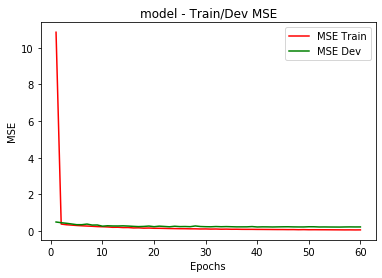

In [34]:
model=experiment(learning_rate=0.04,epochs=60,batch_size=256,steps=300,name='model')

In [35]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 25, 256)           256256    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 322,305
Trainable params: 322,305
Non-trainable params: 0
_________________________________________________________________


In [15]:
## Persist

In [36]:
model.save('/home/kvassay/data/z/models/E5/keras_cnn.h5')